### Data Import & Basic Exploration & Transformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm # run OLS linear regression
from sklearn.linear_model import LinearRegression # linear regression estimator for MICE
from sklearn.experimental import enable_iterative_imputer # experiment setting of imputer for MICE
from sklearn.impute import IterativeImputer # imputer for MICE

In [2]:
cars = pd.read_csv("../W7/train.csv")
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


*Observations:*  
*Fuel_Type, Transmission, and Owner_Type should be categorical.*  
*Mileage, Engine, and Power should have attached unit stripped and turned to type float.*  
*It is not detected above, but "null" string in Power should be turned to NaN too.*

In [4]:
# variable transformation

# strip units
cars["Mileage"] = cars["Mileage"].str.rstrip(" kmpl")
cars["Mileage"] = cars["Mileage"].str.rstrip(" km/g")
cars["Engine"] = cars["Engine"].str.rstrip(" CC")
cars["Power"] = cars["Power"].str.rstrip(" bhp")

# replace null string with NaN
cars["Power"] = cars["Power"].replace(regex="null", value = np.nan)

# convert object type to categorical type
cars["Fuel_Type"] = cars["Fuel_Type"].astype("category")
cars["Transmission"] = cars["Transmission"].astype("category")
cars["Owner_Type"] = cars["Owner_Type"].astype("category")

# convert object type to float type
cars["Mileage"] = cars["Mileage"].astype("float")
cars["Power"] = cars["Power"].astype("float")
cars["Engine"] = cars["Engine"].astype("float")

# split column
cars["Company"] = cars["Name"].str.split(" ").str[0]
cars["Model"] = cars["Name"].str.split(" ").str[1]+cars["Name"].str.split(" ").str[2]

In [5]:
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company,Model
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75,Maruti,WagonR
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50,Hyundai,Creta1.6
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,4.50,Honda,JazzV
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00,Maruti,ErtigaVDI
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74,Audi,A4New


### 1. Transform Price so that it looks more normal

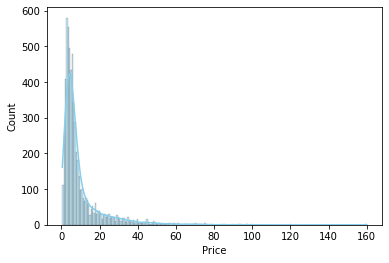

In [6]:
# original price distribution 
sns.histplot(x = cars["Price"], color = "skyblue", label = "Price", kde = True)
plt.show()

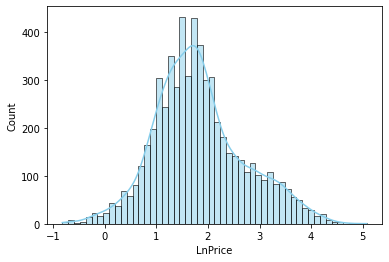

In [7]:
# log-price distribution
cars["LnPrice"] = np.log(cars["Price"])
sns.histplot(x = cars["LnPrice"], color = "skyblue", label = "Price", kde = True)
plt.show()

### 2. How many values are missing for Power and Engine?

In [8]:
print("Power column has", cars["Power"].isna().sum(), "missing values.\n"
      "Engine column has", cars["Engine"].isna().sum(), "missing values.")

Power column has 143 missing values.
Engine column has 36 missing values.


### 3. Which column has the most missing values and what should we do about it?

In [9]:
cars.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                 143
Seats                  42
New_Price            5195
Price                   0
Company                 0
Model                   0
LnPrice                 0
dtype: int64

In [10]:
print(round(cars["New_Price"].isnull().sum()/cars.shape[0]*100,3), "% of data is missing in the New_Price column", sep = "")

86.31% of data is missing in the New_Price column


In [11]:
cars["New_Price"].value_counts()

63.71 Lakh    6
4.78 Lakh     6
95.13 Lakh    6
4.98 Lakh     5
44.28 Lakh    5
             ..
12.14 Lakh    1
12.02 Lakh    1
10.1 Lakh     1
15.94 Lakh    1
79.78 Lakh    1
Name: New_Price, Length: 540, dtype: int64

*New_Price solumn has the most missing values, with 5195 observations missing. Since the percentage missing is as high as 86% and this variable is in our interest, I think it is fair to drop the column.*

### 4. Build a model of transformed price based on Power, Engine, Kilometers Driven, and Year, how much variance is explained?

In [12]:
car1 = cars.loc[:, ["Power", "Engine", "Kilometers_Driven", "Year", "Price", "LnPrice"]]
car1.dropna(inplace = True)
car1.reset_index(inplace=True, drop=True)  # reset index to make continuous index (index missing from NaN removal)
car1.head()

,Power,Engine,Kilometers_Driven,Year,Price,LnPrice
0,58.16,998.0,72000,2010,1.75,0.559616
1,126.20,1582.0,41000,2015,12.50,2.525729
2,88.70,1199.0,46000,2011,4.50,1.504077
3,88.76,1248.0,87000,2012,6.00,1.791759
4,140.80,1968.0,40670,2013,17.74,2.875822


In [13]:
model_drop_na = sm.OLS(car1["LnPrice"], sm.add_constant(car1[["Power", "Engine", "Kilometers_Driven", "Year"]]) ).fit()
model_drop_na.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LnPrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     7279.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:39:27   Log-Likelihood:                -2234.0
No. Observations:                5876   AIC:                             4478.
Df Residuals:                    5871   BIC:                             4511.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -271.9753      3.014    -90.236      0.000    -277.884    -266.067
Power                 0.0088      0.000     50.399      0.000       0.008       0.009
Engine                0.0004   1.56e-05     22.794      0.000       0.000       0.000
Kilometers_Driven  3.426e-09   5.12e-08      0.067      0.947   -9.69e-08    1.04e-07
Year                  0.1352      0.001     90.371      0.000       0.132       0.138
==============================================================================
Omnibus:                     1380.898   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16199.836
Skew:                          -0.786   Prob(JB):                         0.00
Kurtosis:                      10.981   Cond. No.                     7.12e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.12e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*83.2% of variance is explained by the model.*

### 5. How many rows were used to train the model?
*The model summary says "No. Observations: 5876", meaning that 5876 observations were used to train the model.*

### 6. Fill the missing values in Power and Engine with their respective means and rebuild the model. Now how much variance is explained?

In [14]:
car2 = cars.loc[:, ["Power", "Engine", "Kilometers_Driven", "Year", "Price", "LnPrice"]]
car2["Power"].fillna(value = car2["Power"].mean(), inplace = True)
car2["Engine"].fillna(value = car2["Engine"].mean(), inplace = True)

In [15]:
model_fill_mean = sm.OLS(car2["LnPrice"], sm.add_constant(car2[["Power", "Engine", "Kilometers_Driven", "Year"]]) ).fit()
model_fill_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LnPrice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     7219.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:39:27   Log-Likelihood:                -2438.9
No. Observations:                6019   AIC:                             4888.
Df Residuals:                    6014   BIC:                             4921.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -275.1688      2.944    -93.476      0.000    -280.940    -269.398
Power                 0.0084      0.000     48.441      0.000       0.008       0.009
Engine                0.0004   1.54e-05     25.581      0.000       0.000       0.000
Kilometers_Driven -9.706e-09   5.24e-08     -0.185      0.853   -1.12e-07     9.3e-08
Year                  0.1368      0.001     93.594      0.000       0.134       0.140
==============================================================================
Omnibus:                     1161.102   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15841.911
Skew:                          -0.524   Prob(JB):                         0.00
Kurtosis:                      10.878   Cond. No.                     6.83e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*82.8% of variance in outcome is explained by the variables. There is a small drop in R-sqaured in this fill-NA-with-mean model compared to the previous drop-NA model.*

### 7. How many rows were used to train the model?
*The model summary says "No. Observations: 6019", meaning that 6019 observations were used to train the model. Compared to the previous model, more observations were used.*

### 8. Impute the missing data using MICE and rebuild the model

In [16]:
X = cars.loc[:, ["Power", "Engine", "Kilometers_Driven", "Year"]]
lr = LinearRegression()
imp = IterativeImputer(estimator = lr, verbose = 2, max_iter = 100, tol = 1e-10, imputation_order = 'roman')

imp.fit(X)
miceDf = pd.DataFrame(imp.transform(X), columns = ["Power", "Engine", "Kilometers_Driven", "Year"])

[IterativeImputer] Completing matrix with shape (6019, 4)
[IterativeImputer] Ending imputation round 1/100, elapsed time 0.01
[IterativeImputer] Change: 139.89629145912852, scaled tolerance: 0.00065 
[IterativeImputer] Ending imputation round 2/100, elapsed time 0.02
[IterativeImputer] Change: 33.14139332511968, scaled tolerance: 0.00065 
[IterativeImputer] Ending imputation round 3/100, elapsed time 0.03
[IterativeImputer] Change: 25.18748348945246, scaled tolerance: 0.00065 
[IterativeImputer] Ending imputation round 4/100, elapsed time 0.03
[IterativeImputer] Change: 19.142506119394056, scaled tolerance: 0.00065 
[IterativeImputer] Ending imputation round 5/100, elapsed time 0.04
[IterativeImputer] Change: 14.548318837988063, scaled tolerance: 0.00065 
[IterativeImputer] Ending imputation round 6/100, elapsed time 0.05
[IterativeImputer] Change: 11.056733099184385, scaled tolerance: 0.00065 
[IterativeImputer] Ending imputation round 7/100, elapsed time 0.05
[IterativeImputer] Chang

In [17]:
car3 = pd.concat([miceDf, cars["LnPrice"]], axis = 1)
car3.head()

,Power,Engine,Kilometers_Driven,Year,LnPrice
0,58.16,998.0,72000.0,2010.0,0.559616
1,126.20,1582.0,41000.0,2015.0,2.525729
2,88.70,1199.0,46000.0,2011.0,1.504077
3,88.76,1248.0,87000.0,2012.0,1.791759
4,140.80,1968.0,40670.0,2013.0,2.875822


In [18]:
model_fill_mice = sm.OLS(car3["LnPrice"], sm.add_constant(car3[["Power", "Engine", "Kilometers_Driven", "Year"]]) ).fit()
model_fill_mice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LnPrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     7329.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:39:28   Log-Likelihood:                -2401.0
No. Observations:                6019   AIC:                             4812.
Df Residuals:                    6014   BIC:                             4846.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -269.4455      2.940    -91.656      0.000    -275.208    -263.683
Power                 0.0088      0.000     49.466      0.000       0.008       0.009
Engine                0.0004   1.59e-05     22.246      0.000       0.000       0.000
Kilometers_Driven -1.492e-09    5.2e-08     -0.029      0.977   -1.04e-07    1.01e-07
Year                  0.1340      0.001     91.787      0.000       0.131       0.137
==============================================================================
Omnibus:                     1218.061   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16778.317
Skew:                          -0.572   Prob(JB):                         0.00
Kurtosis:                      11.099   Cond. No.                     6.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*83% of the variance in LnPrice can be explained by the 4 variables where null values are filled with the MICE procedure.*

### 9. How have the parameter estimates changed from step 4?

In [19]:
print("\t\tPower\t\t\t\tEngine\t\t\t\tKilometers_Driven\t\tYear")
print("drop NA", model_drop_na.params[1], model_drop_na.params[2], model_drop_na.params[3], model_drop_na.params[4], sep="\t")
print("fill mean", model_fill_mean.params[1], model_fill_mean.params[2], model_fill_mean.params[3], model_fill_mean.params[4], sep="\t")
print("fill MICE", model_fill_mice.params[1], model_fill_mice.params[2], model_fill_mice.params[3], model_fill_mice.params[4], sep="\t")

		Power				Engine				Kilometers_Driven		Year
drop NA	0.00876573168507434	0.00035669292338624277	3.426330136294642e-09	0.1352129373314112
fill mean	0.008393195691603485	0.0003951353657641591	-9.705803963173997e-09	0.13678802055382927
fill MICE	0.00876573166754284	0.0003538971787973637	-1.492226640920685e-09	0.13395934998855852


*The parameter estimates of Power and Engine do not change much whether NA values are dropped, filled with means or filled with MICE imputation. The estimates of them, however, are closer to each other when NA values are dropped and when filled with MICE imputation.*  
*On the other hand, it looks like the coefficients of Kilometers_Driven and Year are changing with different models. However, the coefficients changed very little.*

### 10. Plot the distribution of Power with and without MICE

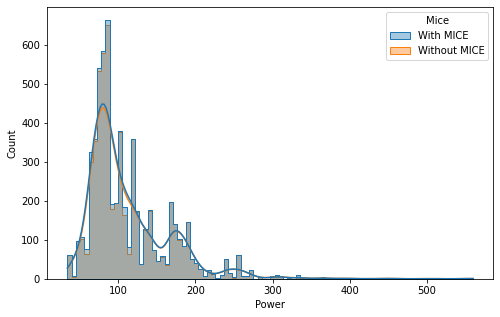

In [20]:
no_mice_power = pd.concat([cars["Power"], pd.DataFrame(["Without MICE"]*cars.shape[0])], axis = 1)
mice_power = pd.concat([car3["Power"], pd.DataFrame(["With MICE"]*car3.shape[0])], axis = 1)
comb_power = pd.concat([no_mice_power, mice_power], axis = 0)
comb_power.rename(columns = {0 : "Mice"}, inplace = True)

plt.figure(figsize=(8,5))
sns.histplot(x=comb_power["Power"], hue=comb_power["Mice"], kde = True,
             alpha = 0.4, multiple="layer", element="step", hue_order=["With MICE", "Without MICE"])
plt.show()

*The two distributions almost overlap with each other , with a slight difference when Power is around 70-120.*

### 11. Plot the distribution of Engine with and without MICE

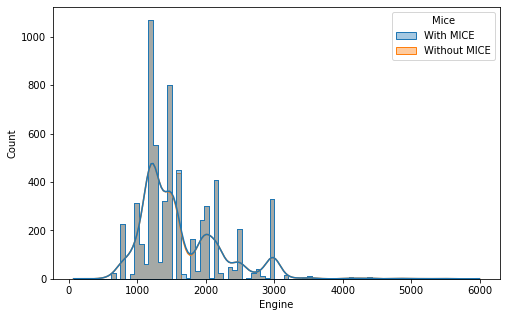

In [21]:
no_mice_engine = pd.concat([cars["Engine"], pd.DataFrame(["Without MICE"]*cars.shape[0])], axis = 1)
mice_engine = pd.concat([car3["Engine"], pd.DataFrame(["With MICE"]*car3.shape[0])], axis = 1)
comb_engine = pd.concat([no_mice_engine, mice_engine], axis = 0)
comb_engine.rename(columns = {0 : "Mice"}, inplace = True)

plt.figure(figsize=(8,5))   
sns.histplot(x=comb_engine["Engine"], hue=comb_engine["Mice"], alpha = 0.4, kde = True, 
            element="step", hue_order=["With MICE", "Without MICE"])
plt.show()

*The two distributions are almost the same. There is only a small difference around Engine = 1800.*